# CV SimpleBlob Detector

https://learnopencv.com/blob-detection-using-opencv-python-c/

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import unsharp_mask
from skimage.filters import gaussian
from skimage import color

In [96]:
im = cv2.imread("D:/Users/xmyst/Desktop/FYP Materials/Images/original_images/afm_black_1.jpg", cv2.IMREAD_GRAYSCALE)
im = cv2.resize(im, (800, 800))
print(f"rows={im.shape[0]}, cols={im.shape[1]}")

rows=800, cols=800


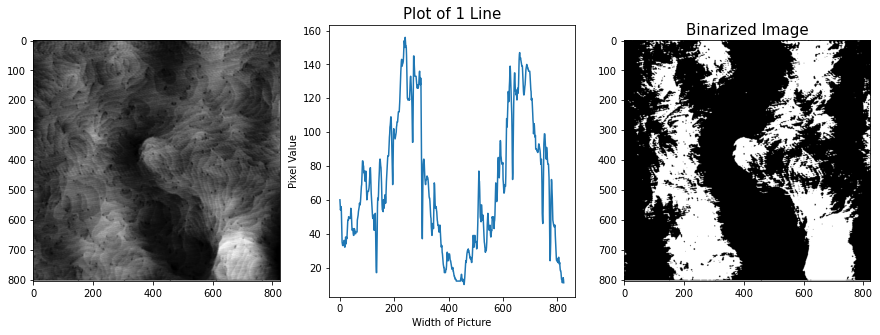

In [43]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(im, cmap="gray")

ax[1].plot(im[600])
ax[1].set_ylabel('Pixel Value')
ax[1].set_xlabel('Width of Picture')
ax[1].set_title('Plot of 1 Line',fontsize=15)

im_b = im > 80
ax[2].set_title('Binarized Image',fontsize=15)
ax[2].imshow(im_b,cmap='gray')

Text(0.5, 0, 'Pixel Intensity')

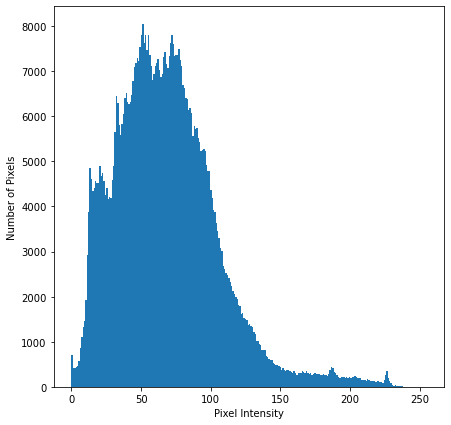

In [44]:
# Image Histogram
# Set total number of bins in the histogram
bins_num = 256

# Get the image histogram
#hist, bin_edges = np.histogram(im, bins=bins_num)
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(im.ravel(), bins_num, [0,255]);
ax.set_ylabel('Number of Pixels')
ax.set_xlabel('Pixel Intensity')

In [92]:
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H

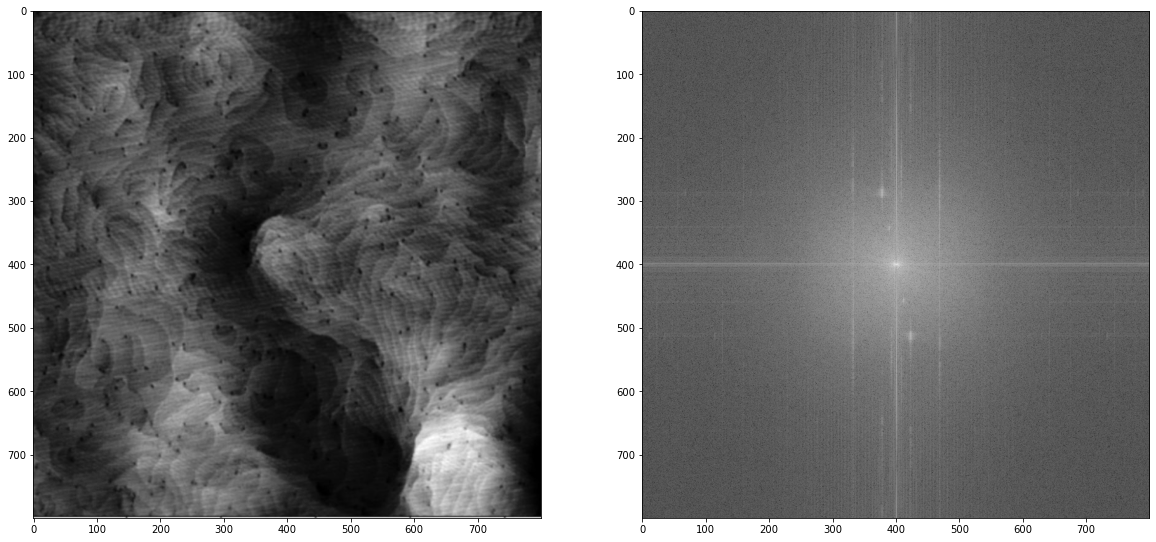

In [82]:
f = np.fft.fft2(im)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].imshow(im, cmap="gray")
ax[1].imshow(magnitude_spectrum, cmap="gray")

'\n# shift back\nNotchReject = np.fft.ifftshift(NotchRejectCenter)\ninverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result\n'

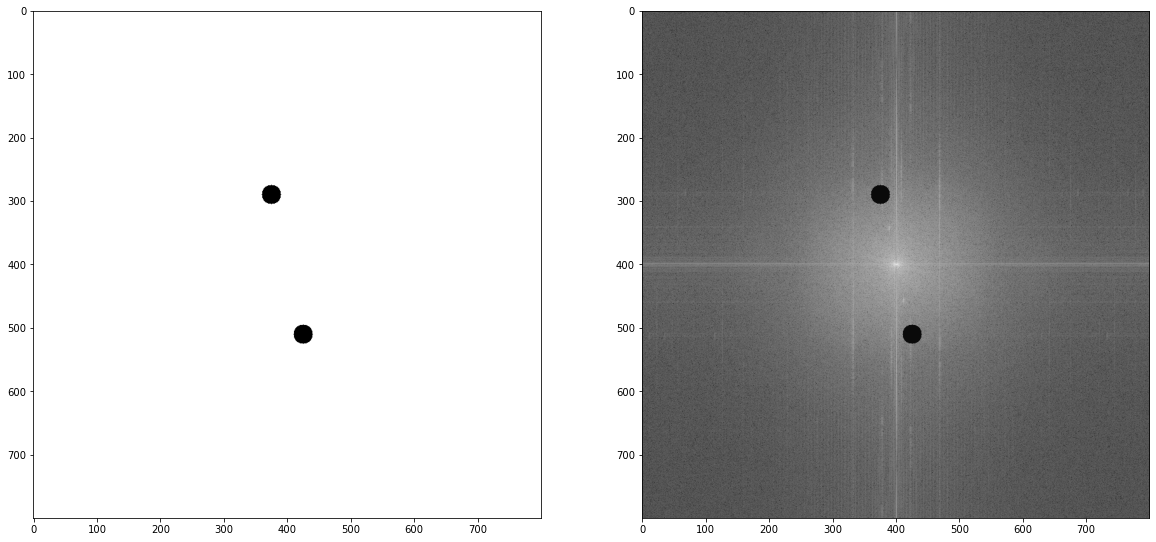

In [93]:
img_shape = im.shape

H1 = notch_reject_filter(img_shape, 15, 110, 25)

NotchFilter = H1
NotchRejectCenter = fshift * NotchFilter 

fig, ax = plt.subplots(1,2 ,figsize=(20,15))
ax[0].imshow(NotchFilter, cmap="gray")
ax[1].imshow(magnitude_spectrum*NotchFilter, cmap="gray")

'''
# shift back
NotchReject = np.fft.ifftshift(NotchRejectCenter)
inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result
'''

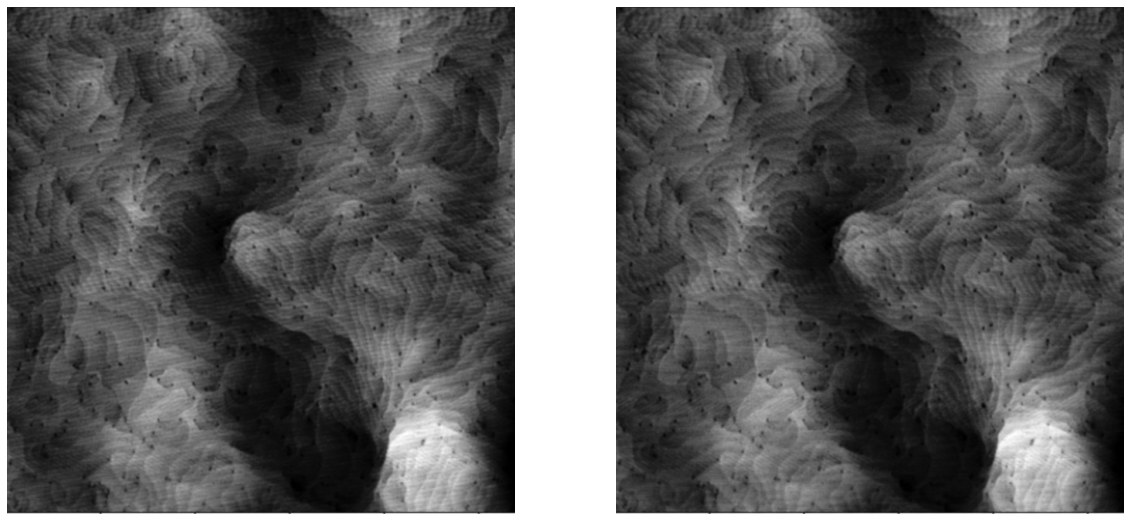

In [94]:
# shift back
NotchReject = np.fft.ifftshift(NotchRejectCenter)
# Compute the inverse DFT of the notch rejected result
inverse_NotchReject = np.fft.ifft2(NotchReject)  
result = np.abs(inverse_NotchReject)

fig, ax = plt.subplots(1,2 ,figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im, cmap="gray")
ax[1].axis("off")
ax[1].imshow(result, cmap="gray")

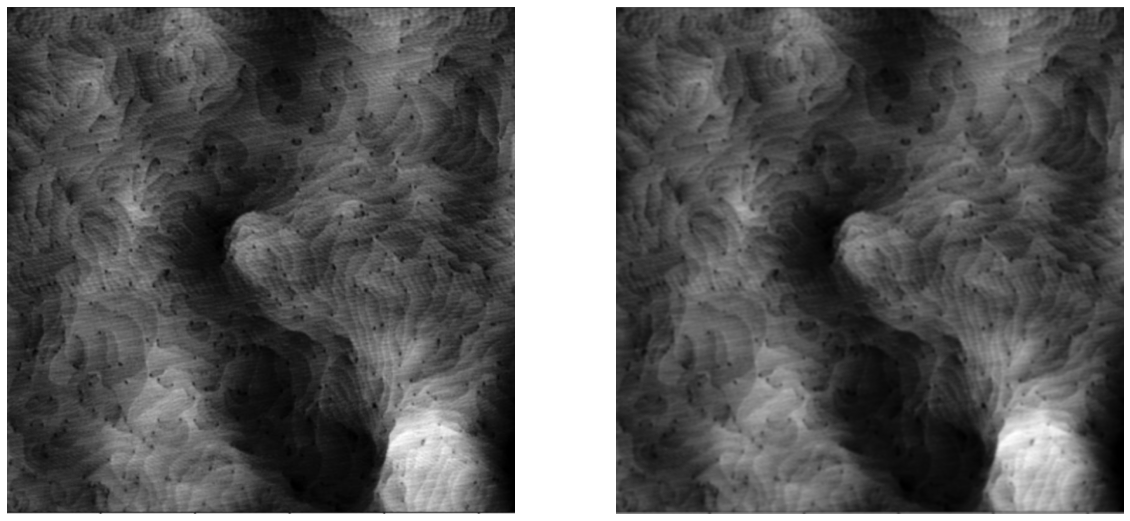

In [91]:
# Gaussian filter
gim = cv2.GaussianBlur(im, (7, 7), 0)
fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im, cmap="gray")
ax[1].axis("off")
ax[1].imshow(gim, cmap="gray")

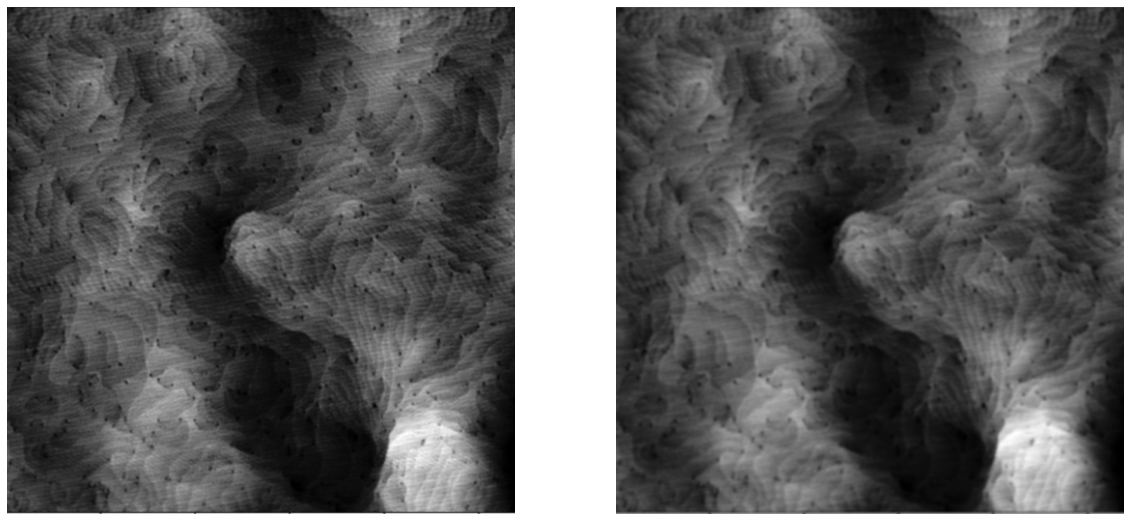

In [90]:
# bilateral filter
bim = cv2.bilateralFilter(im,7,150,150)
fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im, cmap="gray")
ax[1].axis("off")
ax[1].imshow(bim, cmap="gray")

In [97]:
# Function for blob detection
def blobdetect(image):
    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create()
    # Detect blobs.
    keypoints = detector.detect(image)
    # Draw detected blobs as blue circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    print("Blobs detected: " + str(len(keypoints)))
    return im_with_keypoints

Blobs detected: 34


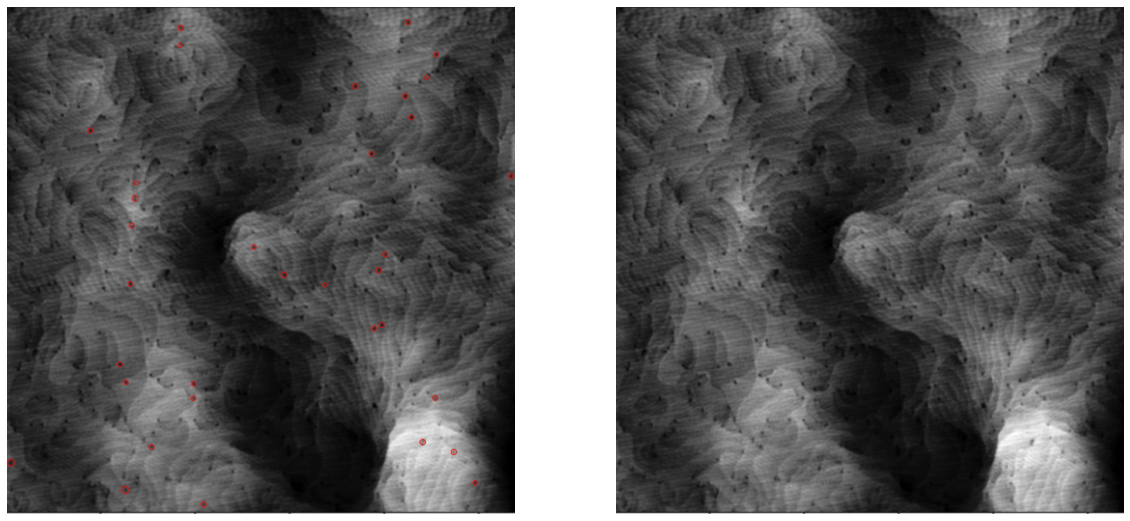

In [98]:
# Blob detection on image with only low-pass filter applied
im_with_keypoints = blobdetect(im)

# Show keypoints
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im_with_keypoints, cmap="gray")
ax[1].axis("off")
ax[1].imshow(im, cmap="gray")

Obtained threshold:  73.0
Blobs detected: 54


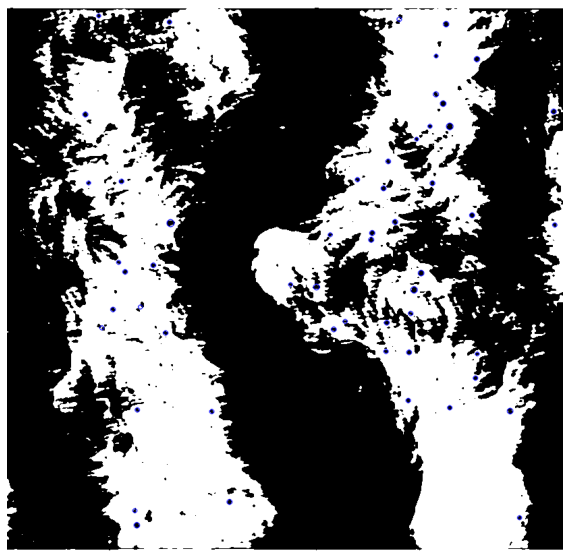

In [7]:
# Apply Otsu Thresholding to get binary image
otsu_threshold, image_result = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
print("Obtained threshold: ", otsu_threshold)

im_with_keypoints = blobdetect(image_result)

# Show Keypoints
fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(im_with_keypoints, cmap="gray")

0 243


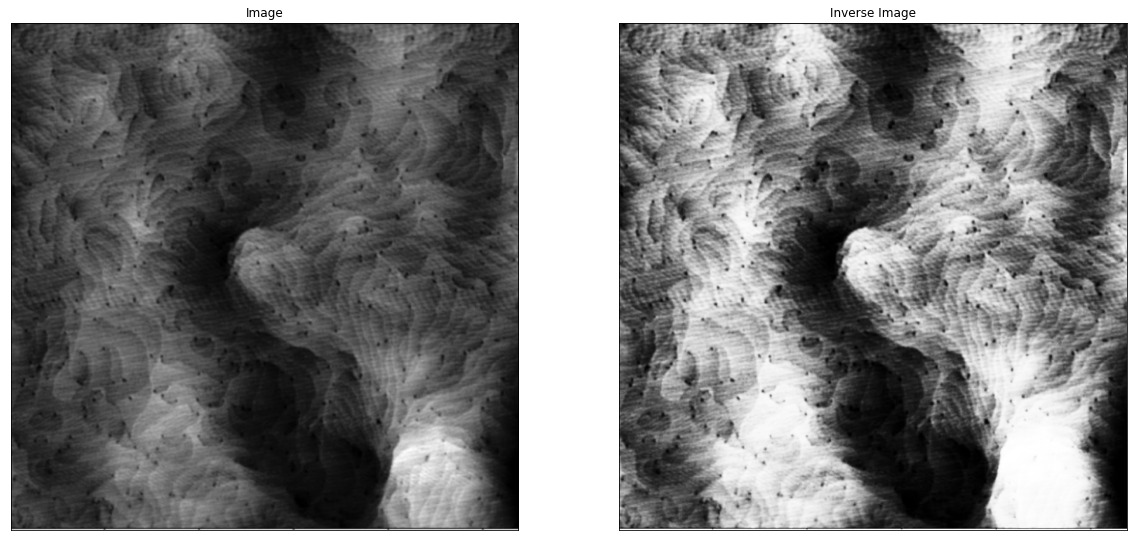

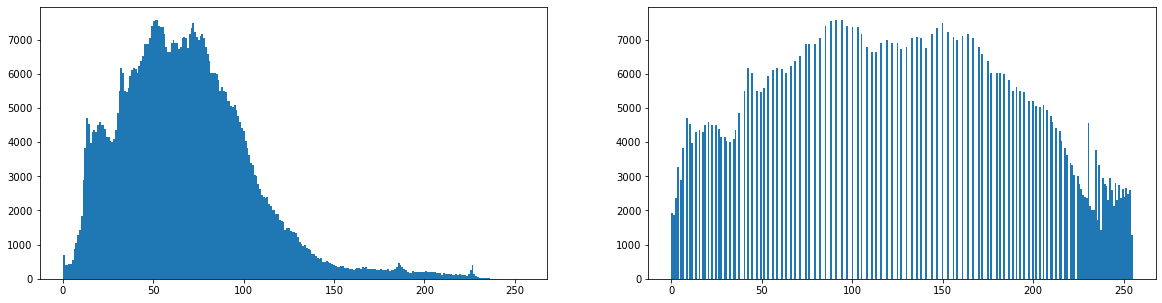

In [99]:
# Apply Histogram Equalization
# Function of histogram equalization
def histeq(im, nbr_bins = 256):
  """ Histogram equalization of a grayscale image.  """
  print(im.min(),im.max())
  # get the image histogram

  imh = np.zeros(nbr_bins)
  n_row = im.shape[0]
  n_col = im.shape[1]
  for x in range(0, n_row):
      for y in range(0, n_col):
          imh[im[x,y]]+=1
  imh = imh/np.sum(imh)
  cdf = np.zeros(nbr_bins)
  cdf[0]=imh[0]
  for x in range(1, nbr_bins):
      cdf[x] = cdf[x-1]+imh[x]

  cdf = cdf/cdf.max()   #normalize
 
  g = np.zeros(nbr_bins)
  for x in range(im.min(), im.max()):
      g[x] = np.round((cdf[x]-cdf[im.min()])/(1.0-cdf[im.min()])*(nbr_bins-1))
  for x in range(im.max(), nbr_bins):
      g[x] = nbr_bins-1
 
  n_row = im.shape[0]
  n_col = im.shape[1]
  ime = np.copy(im)
  for x in range(0, n_row):
      for y in range(0, n_col):
          ime[x,y] = g[im[x,y]]
  return ime

imgg = im.astype(np.uint8)
imggeq = histeq(imgg)

plt.figure(figsize=([20, 20]))
plt.subplot(121),plt.imshow(imgg, cmap = 'gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(imggeq, cmap = 'gray')
plt.title('Inverse Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=([20, 5]))
plt.subplot(121), plt.hist(imgg.ravel(), 256, [0,255]);
plt.subplot(122), plt.hist(imggeq.ravel(), 256, [0,255]);

Blobs detected: 165


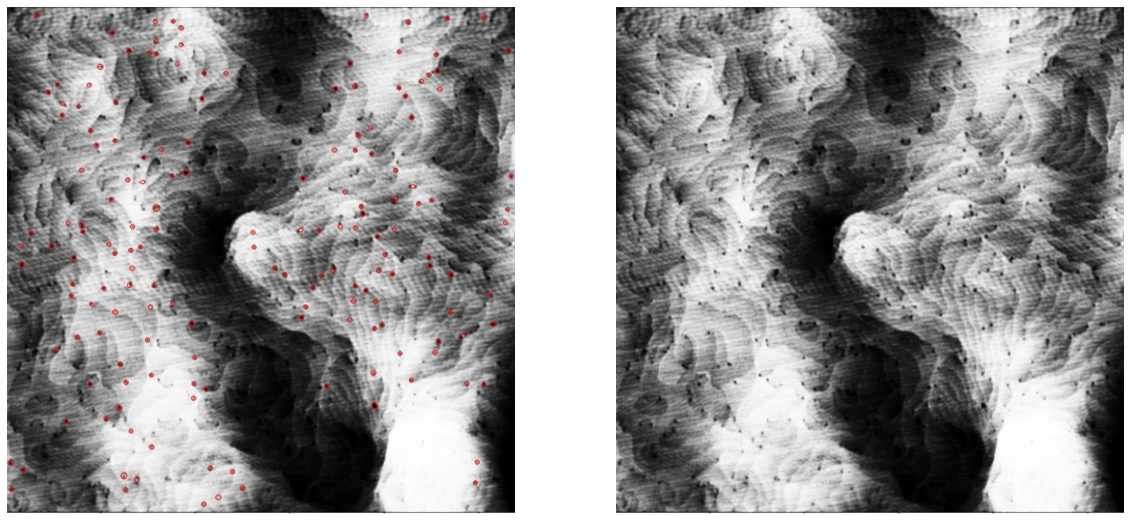

In [100]:
im_with_keypoints = blobdetect(imggeq)

# Show keypoints
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im_with_keypoints, cmap="gray")
ax[1].axis("off")
ax[1].imshow(imggeq, cmap="gray")

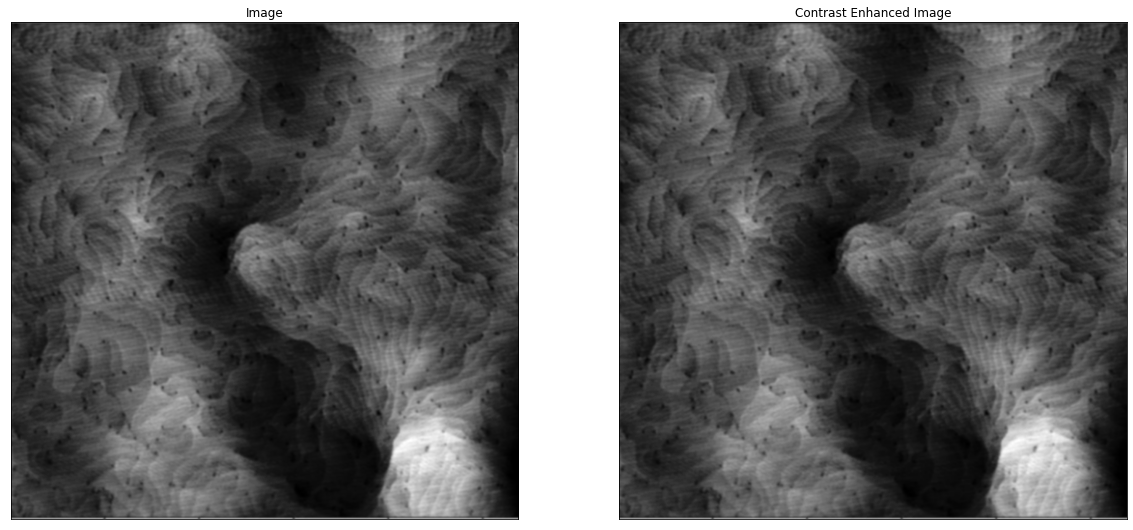

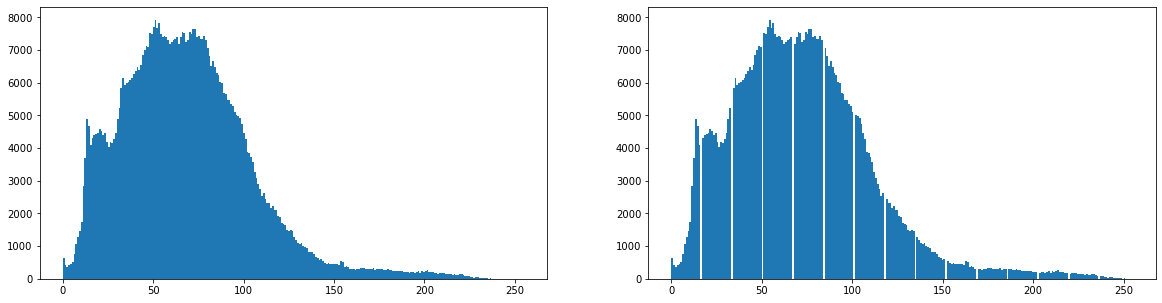

In [10]:
def stretch(im, min, max, im_type):
  orgmax = im.max()
  orgmin = im.min()
  im = (max-min)/(orgmax-orgmin) * (im-orgmin) + min 
  return im.astype(im_type)

imgg = im.astype(np.uint8)
imggst = stretch(imgg,0,255,np.uint8)

plt.figure(figsize=([20, 20]))
plt.subplot(121),plt.imshow(imgg, cmap = 'gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(imggst, cmap = 'gray')
plt.title('Contrast Enhanced Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=([20, 5]))
plt.subplot(121), plt.hist(imgg.ravel(), 256, [0,255]) 
plt.subplot(122), plt.hist(imggst.ravel(), 256, [0,255]) 
plt.show()

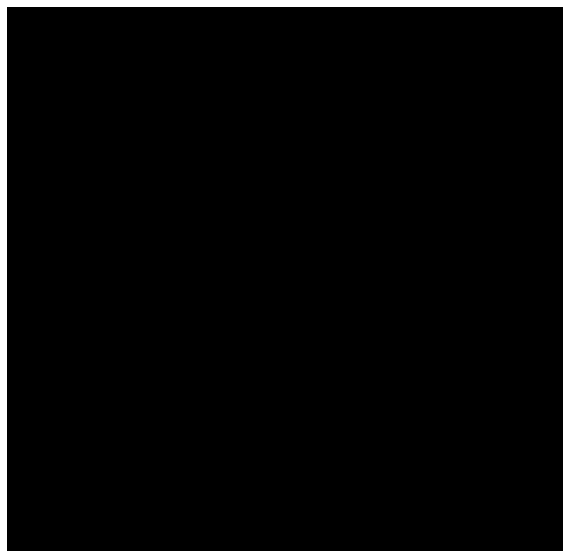

In [11]:
# Tutorial on how to change each pixel value of an image
n_row = im.shape[0]
n_col = im.shape[1]
test_im = np.copy(im)
for x in range(0, n_row):
    for y in range(0, n_col):
        test_im[x,y] = test_im[x,y] - test_im[x,y]

# Show Keypoints
fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(test_im, cmap="gray")

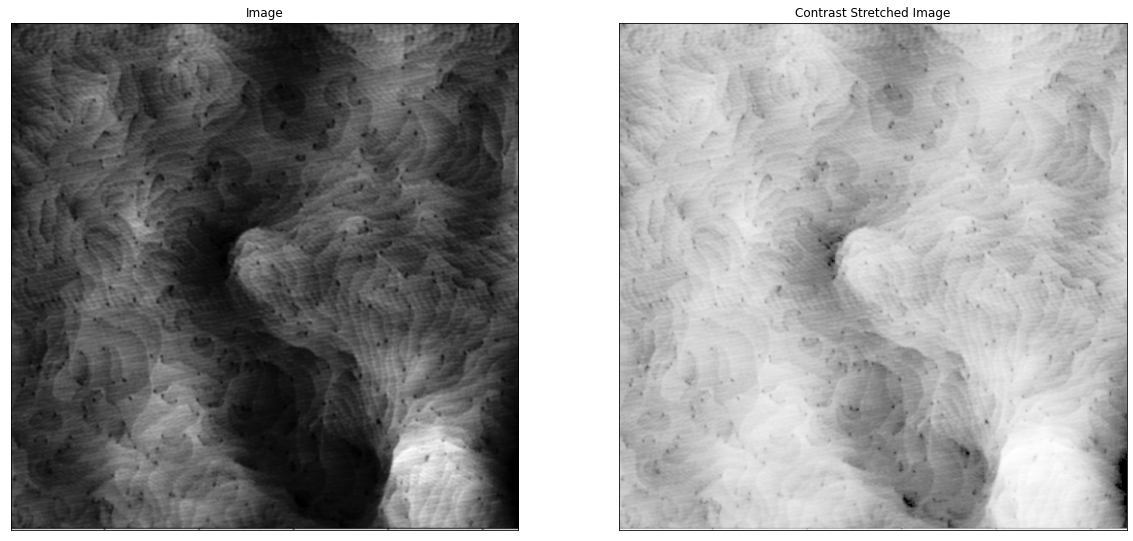

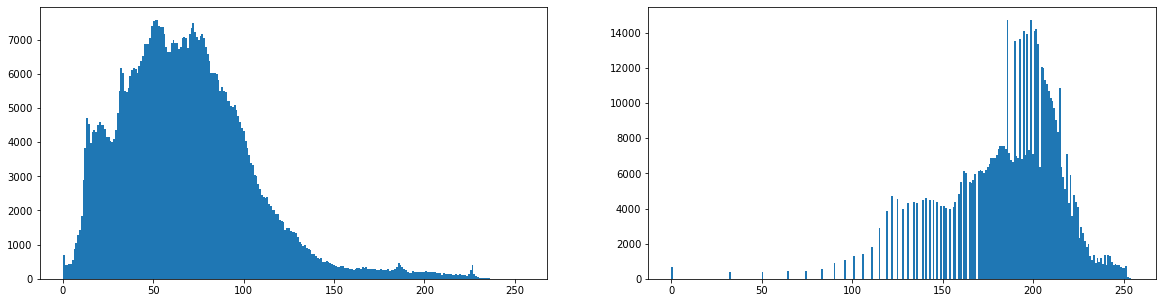

In [101]:
def stretch(im, min, max, im_type):
  orgmax = im.max()
  orgmin = im.min()
  im = (max-min)/(orgmax-orgmin) * (im-orgmin) + min 
  return im.astype(im_type)

imgg = im.astype(np.uint8)
imggst = stretch(np.log(imgg+1),0,255,np.uint8)

plt.figure(figsize=([20, 20]))
plt.subplot(121),plt.imshow(imgg, cmap = 'gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(imggst, cmap = 'gray')
plt.title('Contrast Stretched Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=([20, 5]))
plt.subplot(121), plt.hist(imgg.ravel(), 256, [0,255]) 
plt.subplot(122), plt.hist(imggst.ravel(), 256, [0,255]) 
plt.show()

Blobs detected: 33


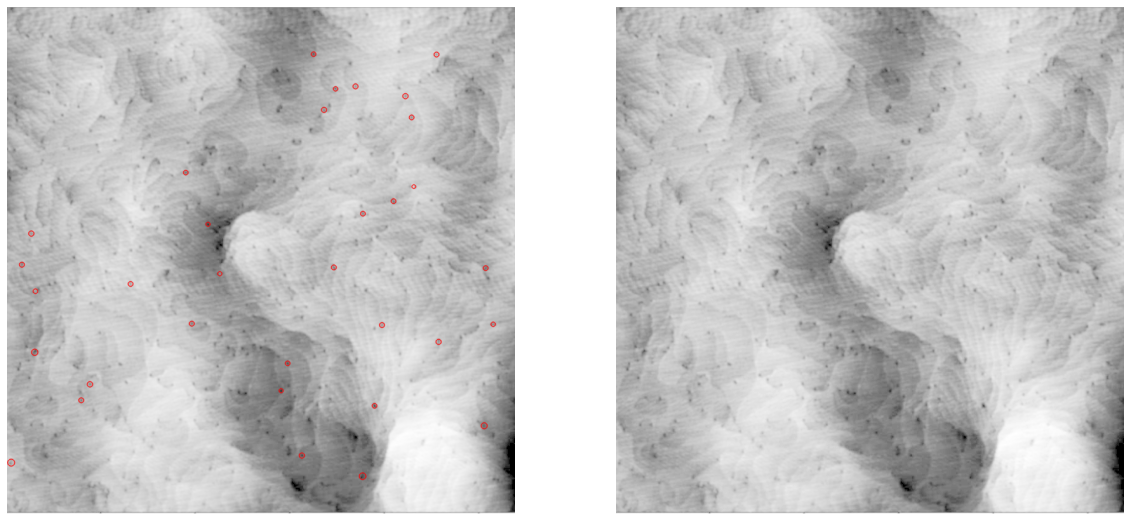

In [102]:
im_with_keypoints = blobdetect(imggst)

# Show keypoints
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im_with_keypoints, cmap="gray")
ax[1].axis("off")
ax[1].imshow(imggst, cmap="gray")

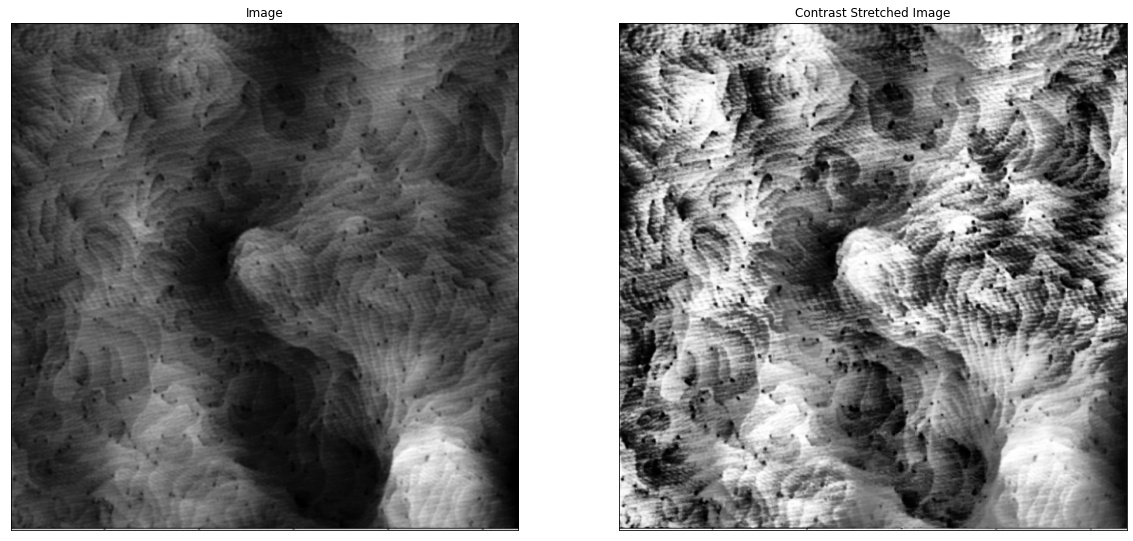

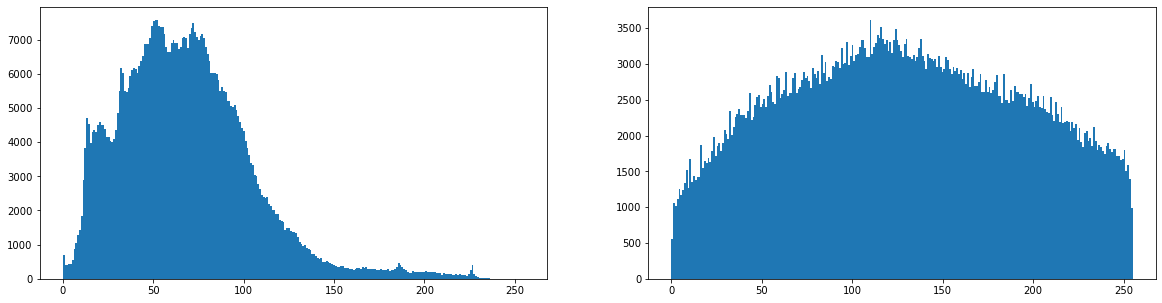

In [103]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(6,6))
cl1 = clahe.apply(im)

plt.figure(figsize=([20, 20]))
plt.subplot(121),plt.imshow(im, cmap = 'gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cl1, cmap = 'gray')
plt.title('Contrast Stretched Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.figure(figsize=([20, 5]))
plt.subplot(121), plt.hist(im.ravel(), 256, [0,255]) 
plt.subplot(122), plt.hist(cl1.ravel(), 256, [0,255]) 
plt.show()

Blobs detected: 191


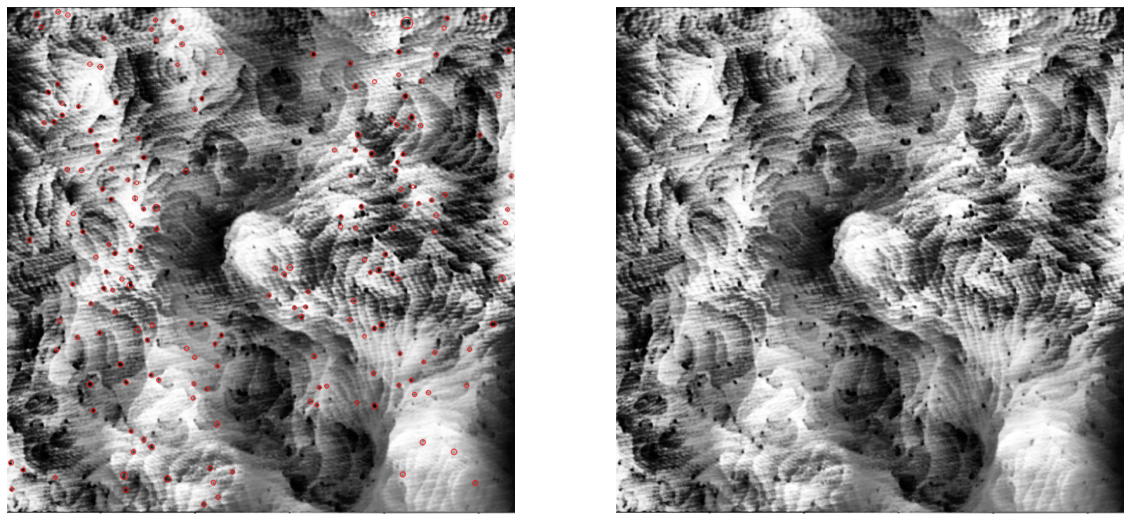

In [104]:
im_with_keypoints = blobdetect(cl1)

# Show keypoints
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].axis("off")
ax[0].imshow(im_with_keypoints, cmap="gray")
ax[1].axis("off")
ax[1].imshow(cl1, cmap="gray")

rows=301, cols=281
0 149
Blobs detected: 1
Blobs detected: 11


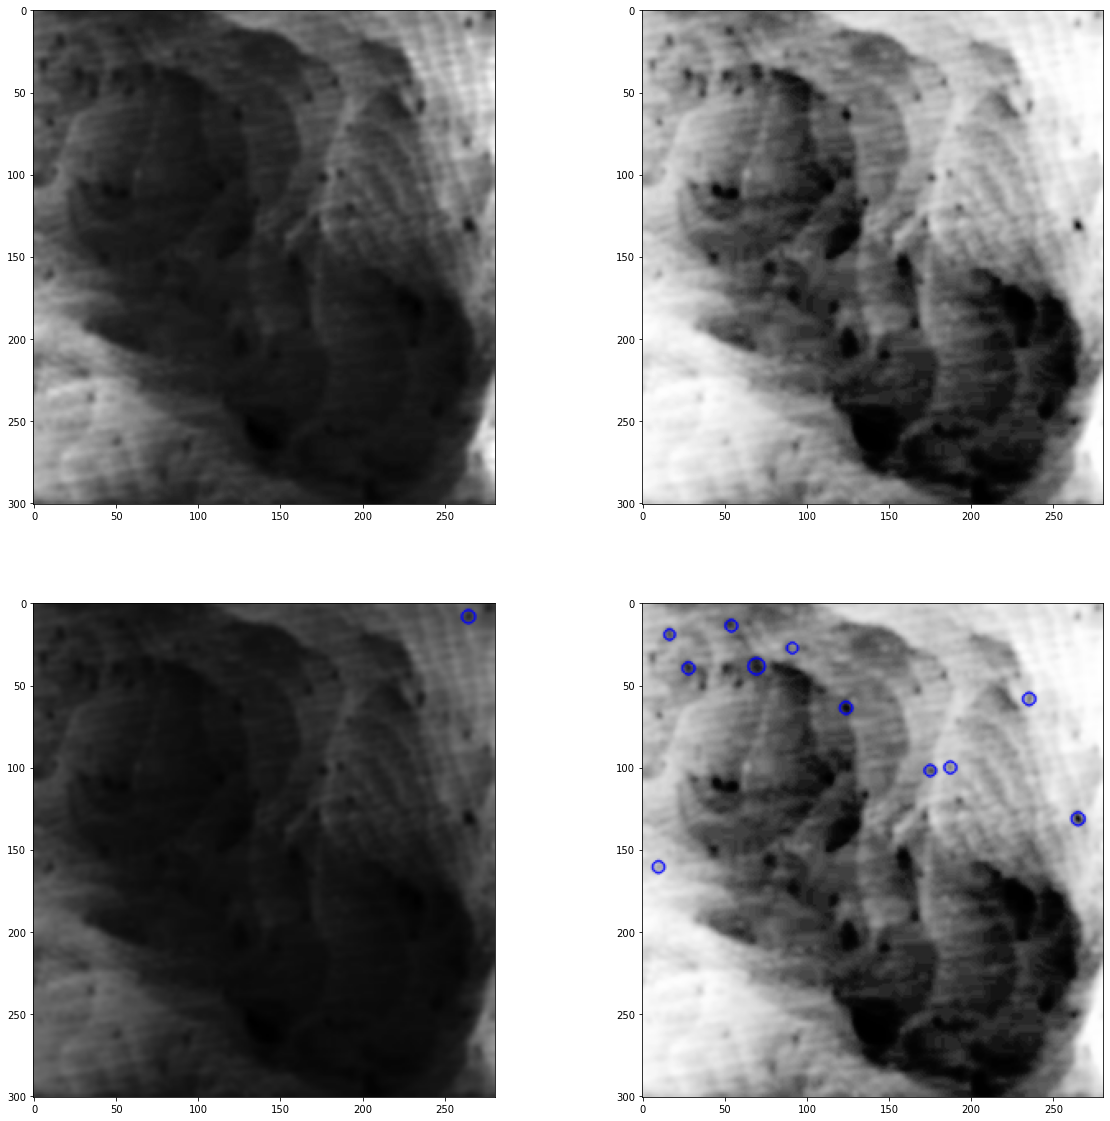

In [169]:
im_cropped = cv2.imread("D:/Users/xmyst/Desktop/FYP Materials/Images/afm_black_1_cropped_dark2.jpg", cv2.IMREAD_GRAYSCALE)
print(f"rows={im_cropped.shape[0]}, cols={im_cropped.shape[1]}")
im_cropped = cv2.GaussianBlur(im_cropped, (5, 5), 0)
imgg = im_cropped.astype(np.uint8)
im_eq = histeq(imgg)
im_cropped_with_keypoints = blobdetect(im_cropped)
im_eq_with_keypoints = blobdetect(im_eq)

fig, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0,0].imshow(im_cropped, cmap="gray")
ax[0,1].imshow(im_eq, cmap="gray")
ax[1,0].imshow(im_cropped_with_keypoints, cmap="gray")
ax[1,1].imshow(im_eq_with_keypoints, cmap="gray")